<a href="https://colab.research.google.com/github/MeRonak/ArtisticStyleTransfer/blob/main/TransferLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# **Neural style transfer**
Neural style transfer is an optimization technique used to take two images—a content image and a style reference image (such as an artwork by a famous painter)—and blend them together so the output image looks like the content image, but “painted” in the style of the style reference image.


# **Inclusion of Libraries**


The primary libraries include torch for tensor computations, torchvision for models, and PIL for image processing.



  **Note: The technique used here is inspired by
A Neural Algorithm of Artistic Style, by Leon A. Gatys, Alexander S. Ecker, Matthias Bethge**


The paper "A Neural Algorithm of Artistic Style" by Leon A. Gatys, Alexander S. Ecker, and Matthias Bethge introduces a novel approach to Neural Style Transfer. The authors propose a method that combines the content of one image with the artistic style of another, creating visually appealing and artistically stylized results. The key innovation lies in using deep neural networks, particularly the VGG network, to separate and manipulate content and style information within an image. By defining appropriate loss functions based on feature representations, the algorithm optimizes a generated image to simultaneously match the content of one image and the style of another. The paper demonstrates the effectiveness of the proposed method through various artistic stylization examples and showcases the potential of deep neural networks in generating aesthetically pleasing images with diverse artistic styles.

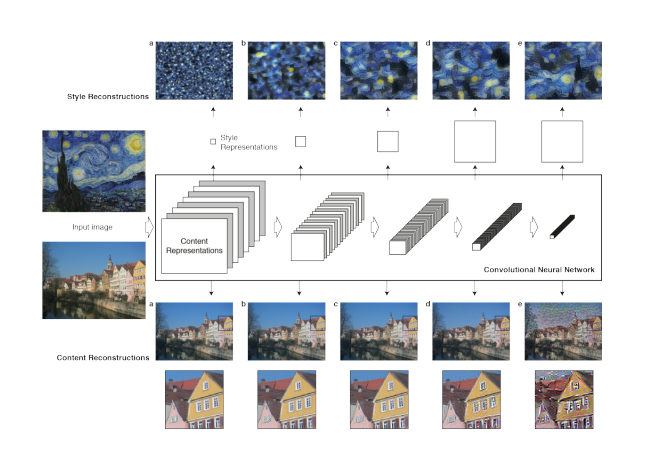


In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.utils import save_image
from PIL import Image

# **Pre-trained VGG19 Model Initialization**
In this section, we initialize a VGG19 model with pre-trained weights using torchvision. VGG19 is a convolutional neural network known for its effectiveness in image classification tasks. Here, we specifically extract its feature layers for further use in Neural Style Transfer.

In [ ]:
model = models.vgg19(pretrained = True).features

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
print(model)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo


# **Custom VGG Model and Image Loading**
In this section, we define a custom VGG model (VGG) tailored for Neural Style Transfer. The model extracts features from specific layers **(['0', '5', '10', '19', '28'])** of a pre-trained VGG19 model. Additionally, a utility function (load_image) is created for loading and pre-processing images.
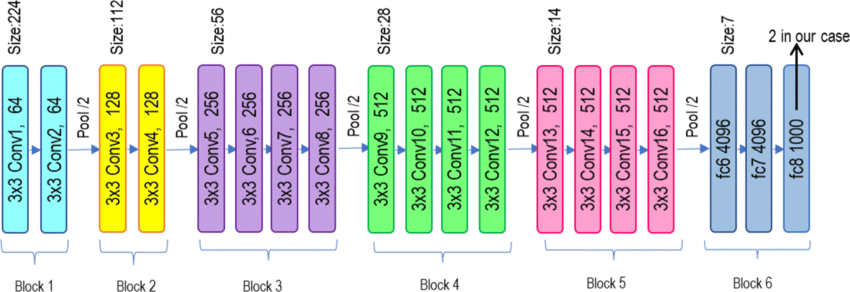


We are going to remove all the fully connected dense layer at the end of VGG19, keep only the convolution layer i.e., (Block 1 - 5). In the paper they define all the convolution block before each layer of maxpool as belonging of same group hence we have 5 groups
We take output from convolution layer of each of this group, here we are going with conv layer just before the Maxpool layer doing so we get the layers  number (['0', '5', '10', '19', '28'])


In [ ]:
class VGG(nn.Module):
    def __init__(self):
        super(VGG, self).__init__()
        self.chosen_features = ['0','5','10','19','28']
        self.model = models.vgg19(pretrained = True).features[:29]
    def forward(self, x):
        features = []
        for layer_number, layer in enumerate(self.model):
            x = layer(x)
            if str(layer_number) in self.chosen_features:
                features.append(x)
        return features
def load_image(image_name):
    image = Image.open(image_name)
    image = loader(image).unsqueeze(0)
    return image.to(device)
device = torch.device("cuda" if torch.cuda.is_available else "cpu")
image_size = 356
loader = transforms.Compose(
    [
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
    ]
)

# **Loading the Images**
Original Image and Art Image whose style we are trying to copy

In [ ]:
original_image = load_image("original.jpg").to(device)
artistic_image = load_image("art.jpg").to(device)
model.to(device)

VGGnet(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

# **Image Generation and Model Initialization**
This section focuses on initializing the image for stylization (generated) by cloning the original image and setting it to require gradients. Additionally, an instance of the custom VGG model (VGG) is created and moved to the specified device for evaluation.

In [ ]:
generated = original_image.clone().requires_grad_(True)
model = VGG().to(device).eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# **Parameter optimization**

In [ ]:
total_steps = 5000
Alpha = 1
Beta = 0.08
optimizer = optim.Adam([generated], lr = 0.001)

# **Optimization Loop**
This code block defines the optimization loop for Neural Style Transfer. The generated image is iteratively updated to minimize the total loss, which is a combination of content and style losses.




1.) The loop iterates for a specified number of total_steps.

2.) Features from the VGG model are extracted for the generated, original, and artistic images.

3.) Content loss (original_loss) is calculated as the mean squared 4.)difference between generated and original features.

4.) Style loss (artistic_loss) is computed based on Gram matrices of the features.

5.) The total loss is a weighted combination of content and style losses.

6.) Gradients are zeroed, backpropagation is performed, and the optimizer updates the generated image.

7.) If the current step is a multiple of 200, the total loss is printed, and the generated image is saved.



In [ ]:
for step in range(total_steps):
  generated_features = model(generated)
  original_image_features = model(original_image)
  artistic_image_features = model(artistic_image)

  artistic_loss = 0
  original_loss = 0

  for gf, of, af in zip(generated_features,
                        original_image_features, artistic_image_features):
    batchSize, channel, height, width = gf.shape
    original_loss += torch.mean((gf - of) ** 2)


    g_l = gf.view(channel, height * width).mm(
        gf.view(channel, height*width).t()
    )
    a_l = af.view(channel, height*width).mm(
        af.view(channel, height*width).t()
    )
    artistic_loss += torch.mean((g_l - a_l)**2)
  total_loss = Alpha * original_loss + Beta * artistic_loss
  optimizer.zero_grad()
  total_loss.backward()
  optimizer.step()

  if step % 200 == 0:
    print(total_loss)
    save_image(generated, "generated.png")




tensor(3201.2759, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2840.6418, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2468.4204, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2169.6409, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1954.7189, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1795.0522, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1674.3278, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1579.0728, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1519.7548, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1464.5238, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1379.3829, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1331.1261, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1290.6165, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1255.7240, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1225.5104, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1192.5929, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1167.2328, device='cuda:0', grad_fn=<AddBackward0


# **Styling Image**


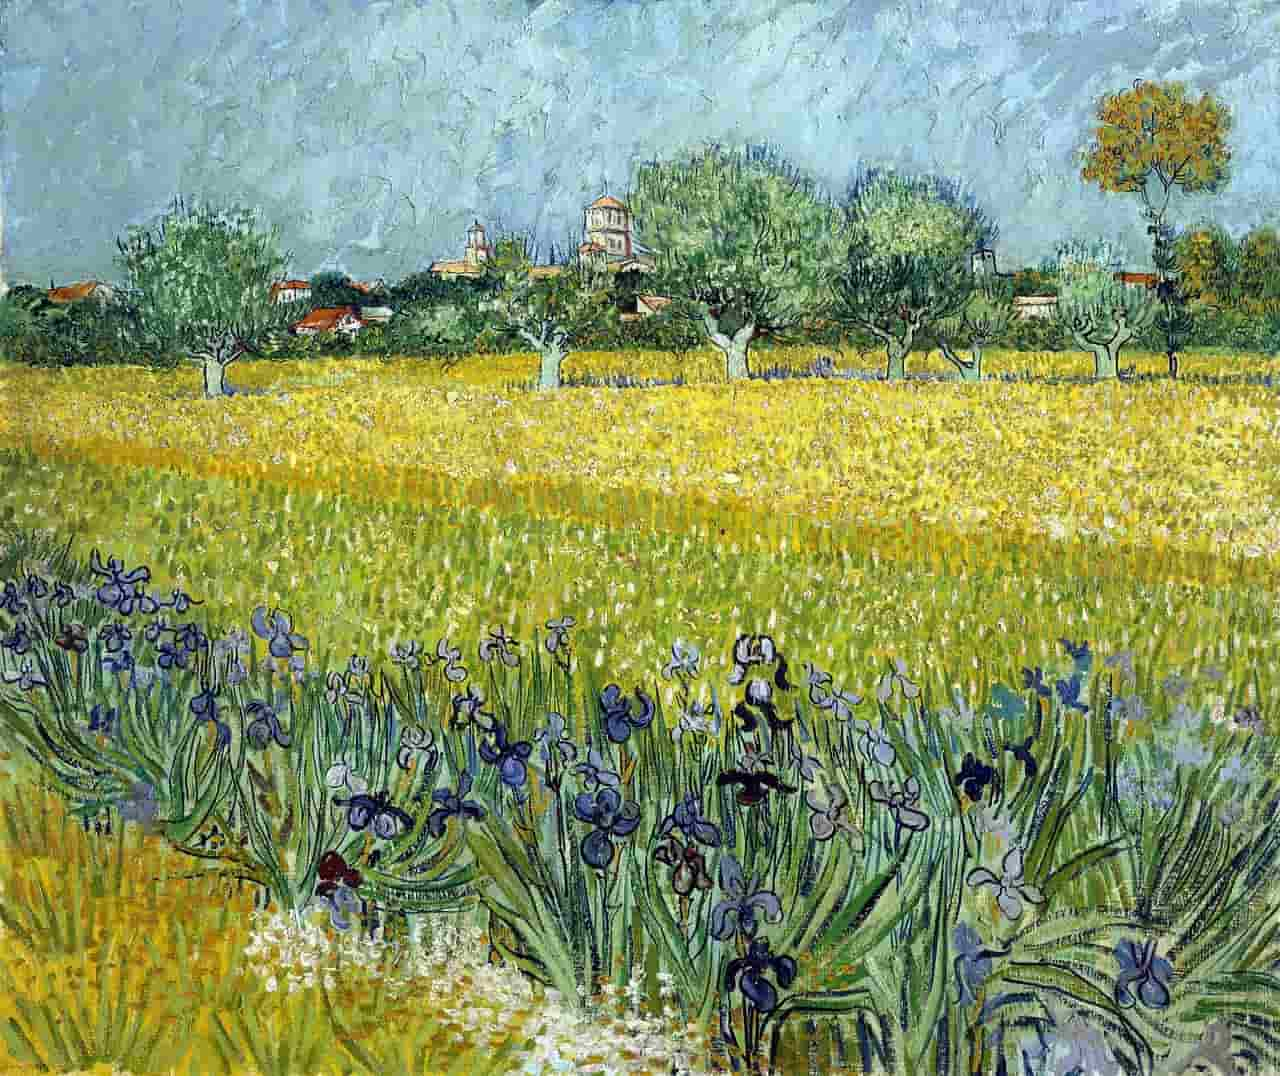

# **Original/Content Image**

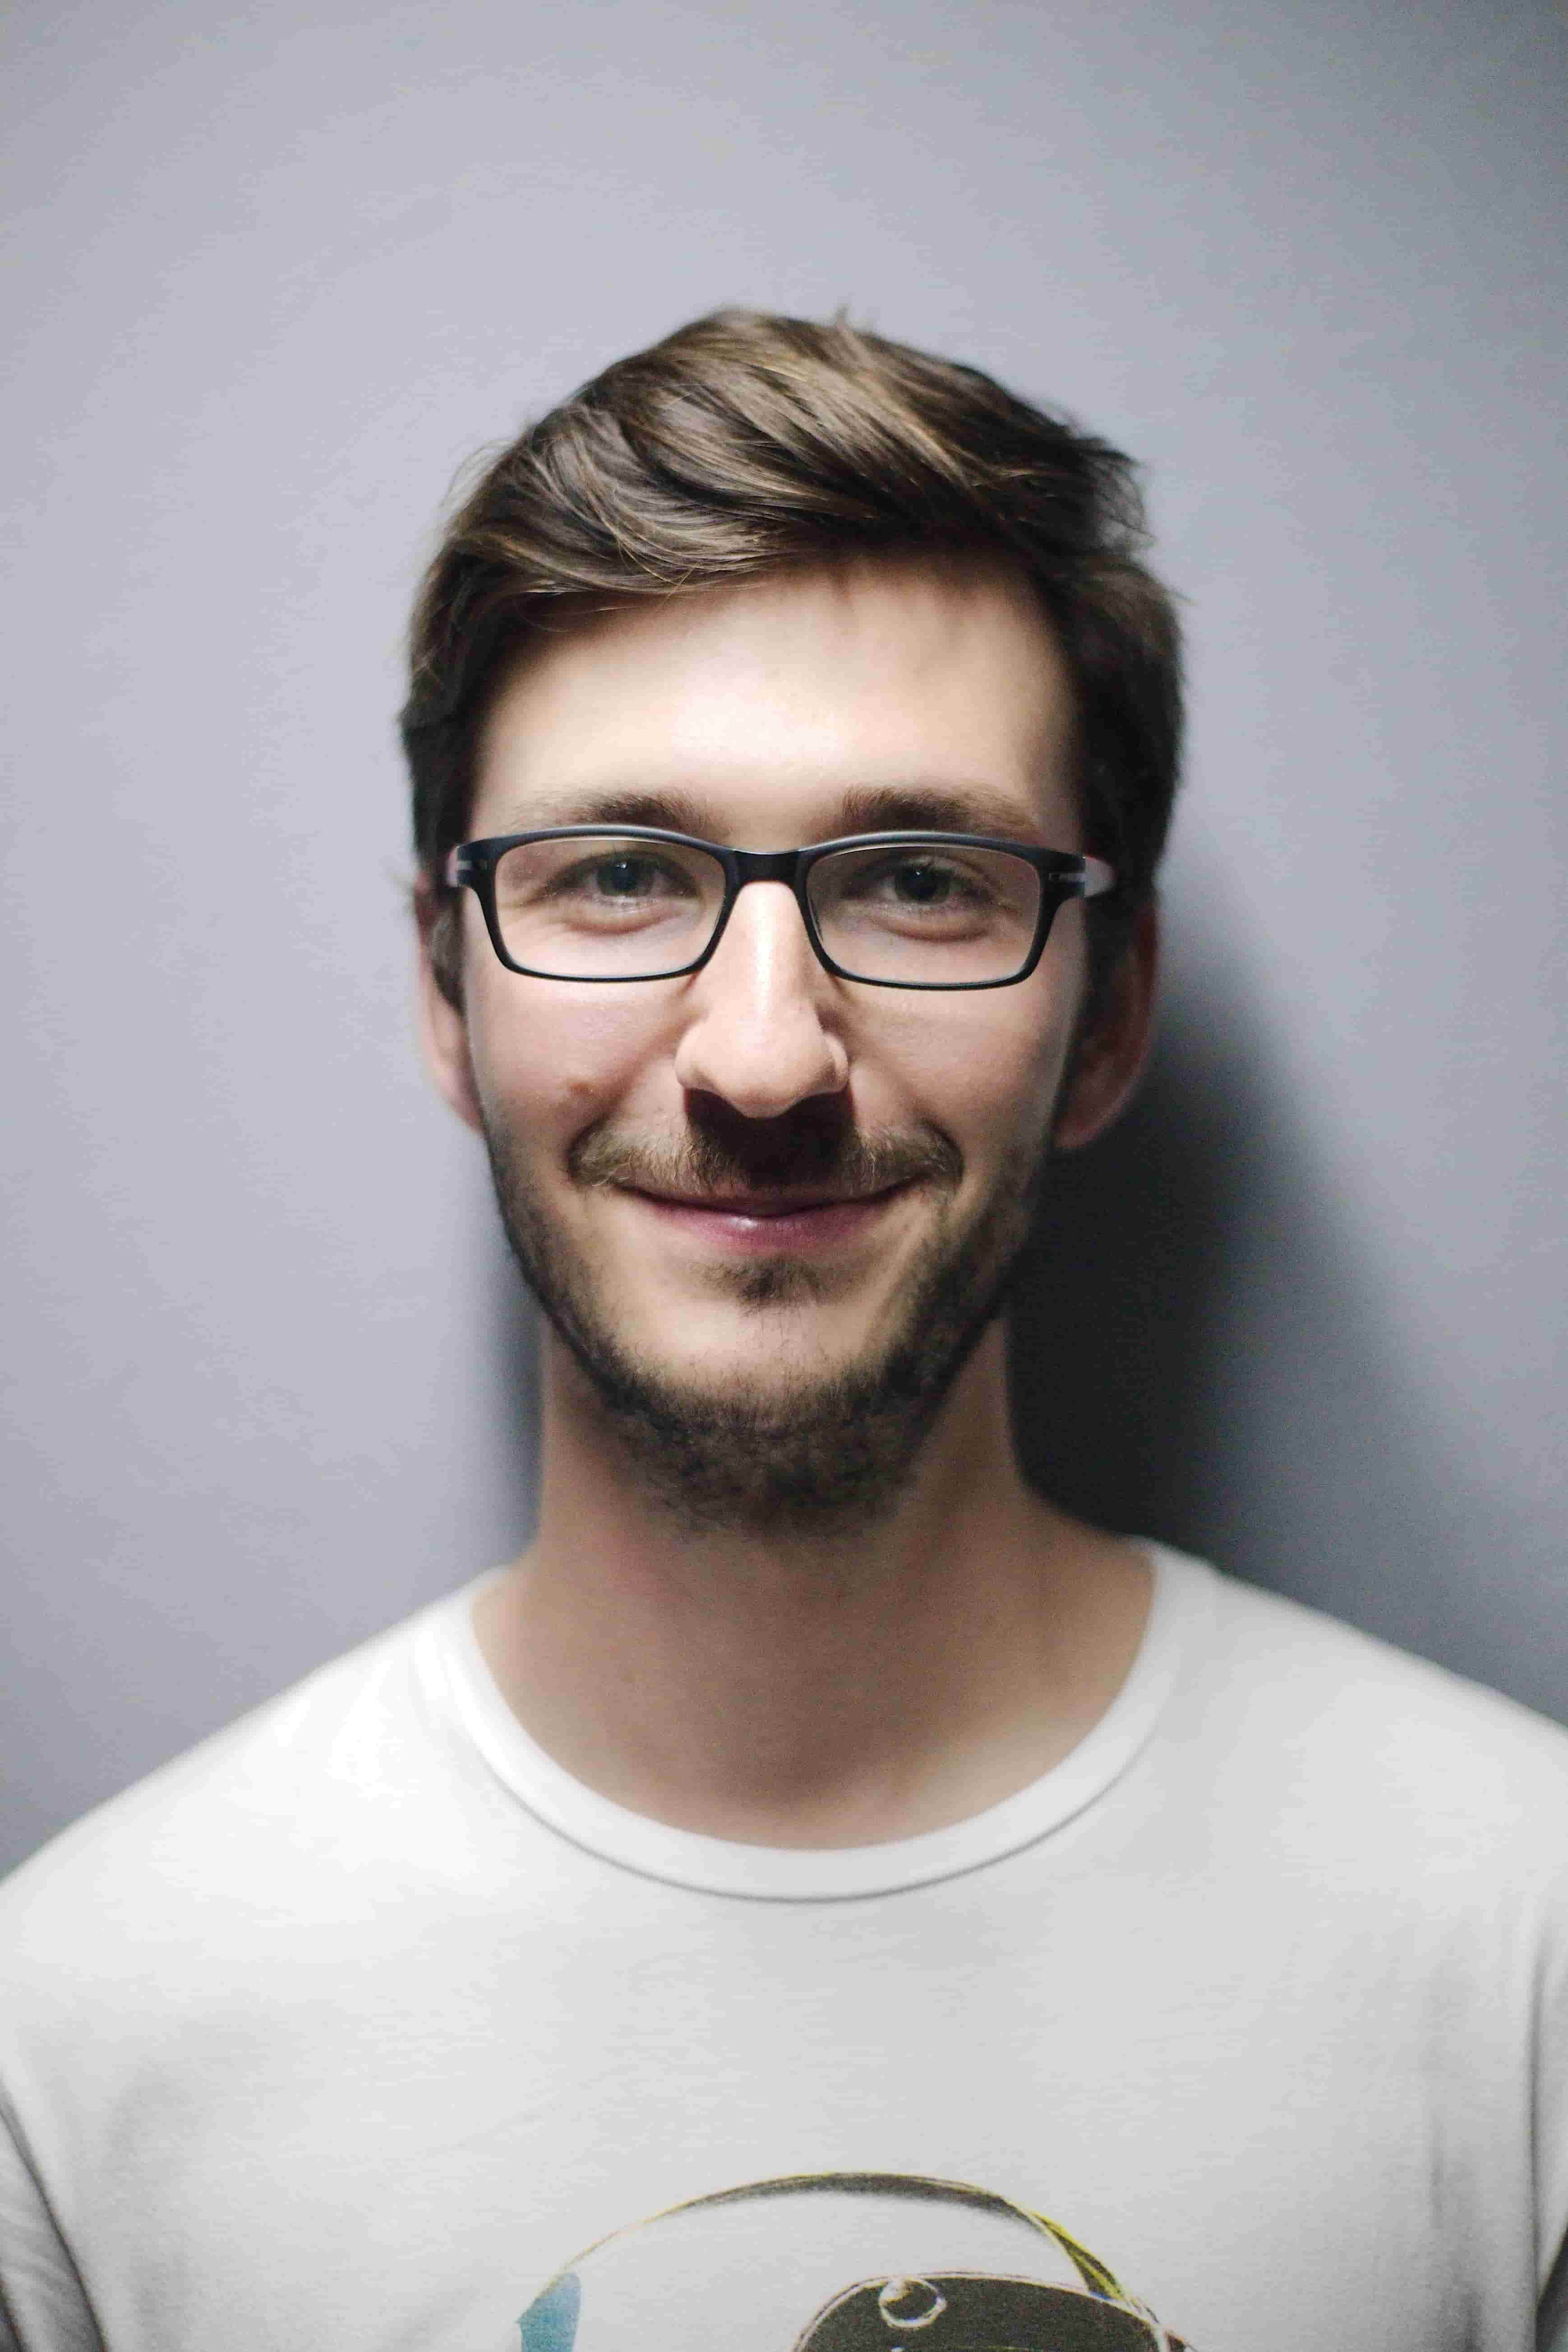

# **Generated Image**
First one is for a Beta value of 0.08 and second for Beta equal to 0.01
Increasing the Beta value would increase the weight of artistic style in generated image
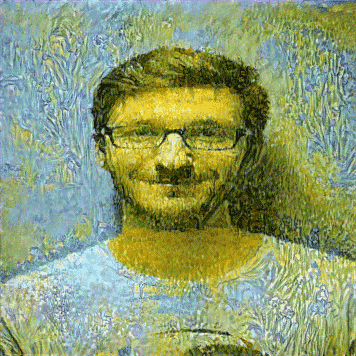
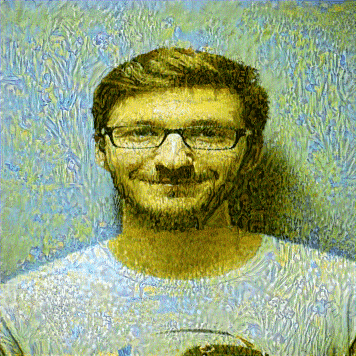

# **References:**


*   [A Neural Algorithm of Artistic Style, by Leon A. Gatys, Alexander S. Ecker, Matthias Bethge](https://arxiv.org/pdf/1508.06576.pdf)
*   https://paperswithcode.com/task/style-transfer

*   https://www.tensorflow.org/tutorials/generative/style_transfer
*   [Convolution Neural Networks, Andrew Ng](https://youtu.be/R39tWYYKNcI?si=CcmhGlPx2lHrk4Lg)
*   https://www.kaggle.com/code/blurredmachine/vggnet-16-architecture-a-complete-guide

*   https://chat.openai.com/ (Mostly for bug fixes and while writing the explaination for each code block)








